## Import packages

In [52]:
import osmnx as ox, networkx as nx, numpy as np, pandas as pd, geopandas as gpd, random, math
import matplotlib.pyplot as plt, matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
from pathlib import Path
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pyproj
import folium
from folium import GeoJson, CircleMarker, Marker, PolyLine, Icon, DivIcon
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D

## Load data

In [53]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"File not found: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' successfully loaded ({len(gdf)} records)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error loading '{nombre_archivo}': {str(e)}")
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' successfully loaded (88 records)
✅ 'catastro.geojson' successfully loaded (36346 records)
✅ 'puntosCID.geojson' successfully loaded (885 records)


## Graph request 

In [54]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
    if len(shp_neighbourhood) != 1:
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.strip().str.upper() == request.strip().upper()]
        if len(shp_neighbourhood) == 1:
            break
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]

    barrio = shp_neighbourhood["nombre"].values[0]
    shp_zone = shp_neighbourhood.geometry.values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(
        shp_zone,
        network_type="all_public",
        simplify=False,
        retain_all=False,
        truncate_by_edge=True
    )

    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']
    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street', 'primary_link', 'primary', 'tertiary', 'trunk', 'service', 'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    allowed_pedestrian = ['pedestrian', 'footway', 'path', 'track', 'bridleway', 'living_street', 'residential']

    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
                       if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()
    G_pedestrian = G.copy()

    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True)
                                if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)

    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True)
                                  if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    G_vehicle = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_pedestrian = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()

    print(f"Graph for {barrio}:")
    print(f"Vehicle graph: {len(G_vehicle.nodes)} nodes, {len(G_vehicle.edges)} edges")
    print(f"Pedestrian graph: {len(G_pedestrian.nodes)} nodes, {len(G_pedestrian.edges)} edges")
    print(f"Loading points: {len(shp_loading_points)} points")
    print(f"Warehouse and store: {len(shp_bajos)} points")

    return barrio, G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos

def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    # --- 1. Visualización de grafos en matplotlib ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].set_aspect('equal', 'box')
    axes[1].set_aspect('equal', 'box')
    ox.plot_graph(G_vehicle, ax=axes[0], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)
    axes[0].set_title("Drive graph")

    ox.plot_graph(G_pedestrian, ax=axes[1], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    axes[1].set_title("Pedestrian graph")
    plt.tight_layout()
    plt.show()

    # --- 2. Mapa interactivo en Folium ---

    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    # --- 2.1 Añadir zona del barrio ---
    folium.GeoJson(
        shp_zone,
        style_function=lambda feature: {
            "color": "limegreen", "weight": 6, "fill": True,
            "fillColor": "limegreen", "fillOpacity": 0.2
        }
    ).add_to(mapa)

    # --- 2.2 Función para añadir aristas ---
    def add_edges(gdf_edges, color, group_name):
        for _, row in gdf_edges.iterrows():
            if row.geometry.geom_type == "LineString":
                tooltip = folium.Tooltip(
                    f"<b>Type:</b> {row.get('highway', 'N/A')}<br>"
                    f"<b>Name:</b> {row.get('name', 'No name')}<br>"
                    f"<b>Length:</b> {round(row.get('length', 0), 1)} m"
                )
                folium.GeoJson(
                    row.geometry,
                    name=group_name,
                    style_function=lambda feature, col=color: {'color': col, 'weight': 2, 'opacity': 1},
                    tooltip=tooltip
                ).add_to(mapa)

    add_edges(gdf_edges_pedestrian, "red", "Pedestrians")
    add_edges(gdf_edges_vehicle, "blue", "Vehicles")

    # --- 2.3 Añadir puntos de carga ---
    for _, row in shp_loading_points.iterrows():
        folium.CircleMarker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=6, color="black", fill=True, fill_color="orange", fill_opacity=1,
            popup=row.get("NOMBRE", "Loading Point")
        ).add_to(mapa)

    # --- 2.4 Añadir puntos bajos (almacenes y comercios) ---
    for _, row in bajos_in_zone.iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue
        centroide = row.geometry.centroid
        if row['Almacen'] and row['Comercio']:
            fill_color, label = 'black', 'Warehouse & Store'
        elif row['Almacen']:
            fill_color, label = 'purple', 'Warehouse'
        else:
            fill_color, label = 'lightblue', 'Store'
        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=6, color='black', fill=True, fill_color=fill_color, fill_opacity=1,
            popup=label
        ).add_to(mapa)

    # --- 2.5 Añadir leyenda personalizada ---
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: 140px;
                background-color: white; z-index:9999; font-size:13px; border:1px solid grey; 
                border-radius: 5px; padding: 8px; box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
        <b style="font-size:14px;">Legend</b><br>
        <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Warehouse & Store<br>
        <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> CiD Point<br>
        <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Warehouse<br>
        <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Store (delivery)<br>
        <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Neighborhood Boundary
    </div>'''
    mapa.get_root().html.add_child(folium.Element(legend_html))

    return mapa



### 🏙️ NEIGHBORHOODS WITH AT LEAST ONE CiD POINT

| AIORA                | ARRANCAPINS          | BENICALAP               | BENIFERRI                |
|----------------------|----------------------|--------------------------|--------------------------|
| BENIFARAIG           | BENIMACLET           | BENIMAMET               | CABANYAL-CANYAMELAR      |
| CAMI DE VERA         | CAMI FONDO           | CAMI REAL               | CAMPANAR                 |
| CASTELLAR-L'OLIVERAL | CIUTAT DE LES ARTS I DE LES CIENCIES | CIUTAT FALLERA | CIUTAT JARDI             |
| CIUTAT UNIVERSITARIA | EL BOTANIC           | EL CALVARI              | EL FORN D'ALCEDO         |
| EL GRAU              | EL MERCAT            | EL PALMAR               | EL PERELLONET            |
| EL PLA DEL REMEI     | EN CORTS             | EXPOSICIO               | FAVARA                   |
| JAUME ROIG           | LA CARRASCA          | LA CREU COBERTA         | LA CREU DEL GRAU         |
| LA FONTETA S.LLUIS   | LA FONTSANTA         | LA GRAN VIA             | LA LLUM                  |
| LA MALVA-ROSA        | LA PETXINA           | LA PUNTA                | LA RAIOSA                |
| LA ROQUETA           | LA SEU               | LA TORRE                | LA VEGA BAIXA            |
| LES TENDETES         | L'HORT DE SENABRE    | L'ILLA PERDUDA          | L'AMISTAT                |
| MALILLA              | MARXALENES           | MASSARROJOS             | MESTALLA                 |
| MONTOLIVET           | MORVEDRE             | NATZARET                | NOU MOLES                |
| PATRAIX              | PENYA-ROJA           | PINEDO                  | RUSSAFA                  |
| SAFRANAR             | SANT ANTONI          | SANT FRANCESC           | SANT ISIDRE              |
| SANT LLORENS         | SANT MARCEL.LI       | SANT PAU                | SOTERNES                 |
| TORMOS               | TORREFIEL            | TRINITAT                | TRES FORQUES             |
| VARA DE QUART        | ALBORS               | BETERO                  |                          |



Graph for SANT FRANCESC:
Vehicle graph: 427 nodes, 466 edges
Pedestrian graph: 1315 nodes, 2850 edges
Loading points: 13 points
Warehouse and store: 511 points


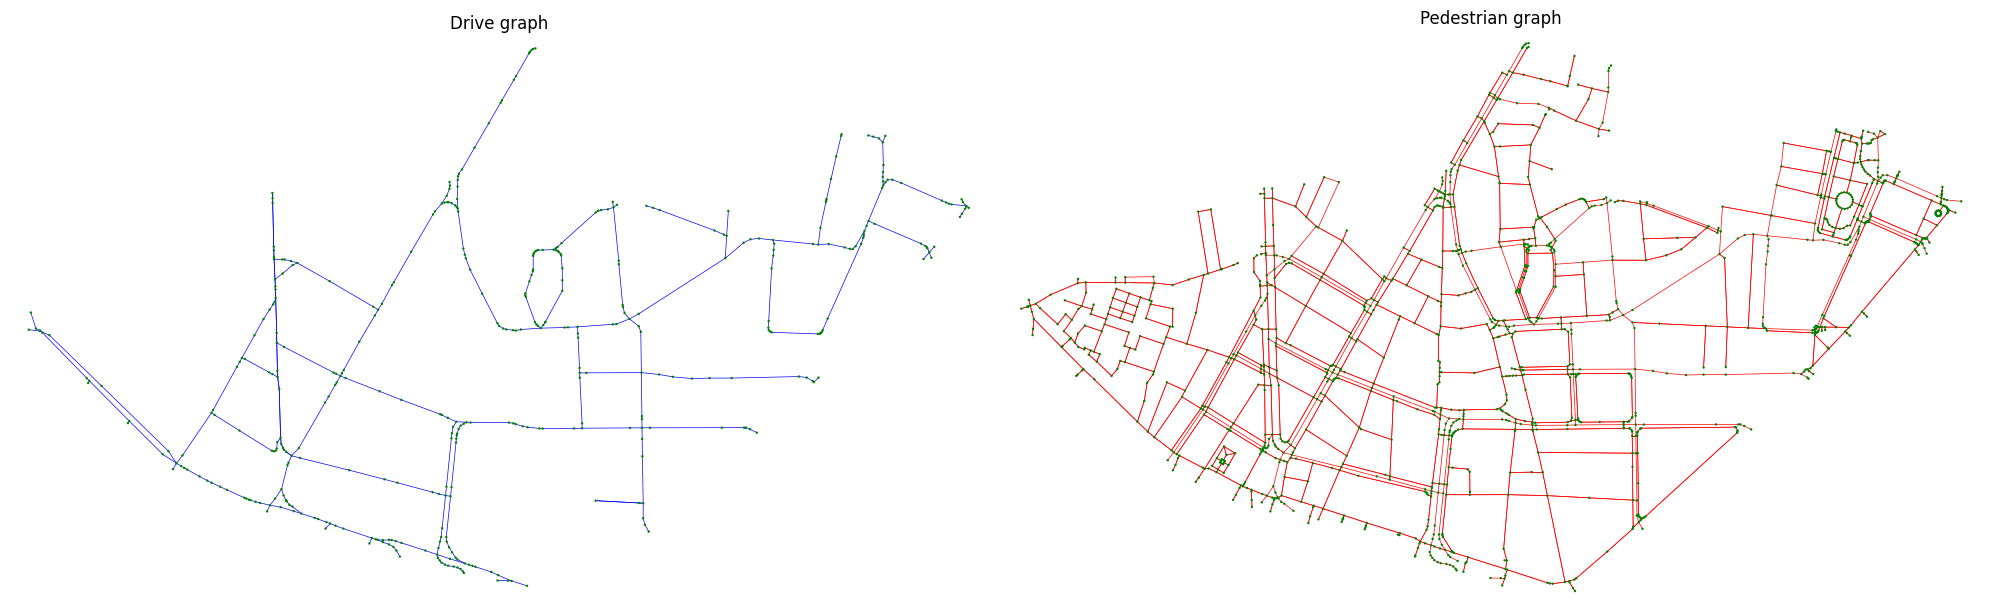

In [55]:
barrio, G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('SANT FRANCESC')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

## Supergraph building

In [56]:
# --- 1. Crear supergrafo vacío y añadir nodos ---
G_super = nx.MultiDiGraph()
G_super.add_nodes_from(G_drive.nodes(data=True))
G_super.add_nodes_from(G_walk.nodes(data=True))

# --- 2. Función para añadir o fusionar aristas con múltiples modos ---
def add_or_merge_edge(G, u, v, key, data, mode):
    data = data.copy()
    modos = data.get('mode', [])
    if not isinstance(modos, list):
        modos = [modos]
    if mode not in modos:
        modos.append(mode)
    data['mode'] = modos

    # Fusionar si existe arista con misma geometría
    if G.has_edge(u, v):
        for k_exist, existing in G[u][v].items():
            if existing.get('geometry') == data.get('geometry'):
                exist_mod = existing.get('mode', [])
                if not isinstance(exist_mod, list):
                    exist_mod = [exist_mod]
                for m in modos:
                    if m not in exist_mod:
                        exist_mod.append(m)
                existing['mode'] = exist_mod
                return
    G.add_edge(u, v, key=key, **data)

# Añadir aristas de conducción
for u, v, k, data in G_drive.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'drive')

# Añadir aristas de caminata (bidireccional)
for u, v, k, data in G_walk.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'walk')
    if not G_walk.has_edge(v, u):
        add_or_merge_edge(G_super, v, u, k, data, 'walk')

# --- Auxiliar: función haversine para distancia geodésica en metros ---
def haversine(coord1, coord2):
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    # convertir grados a radianes
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    R = 6371000  # Radio de la Tierra en metros
    return R * c

# --- 3. Función para añadir nodos especiales usando lat/lon ---
def add_special_node(G, geom, tipo, idx):
    nodo_id = f"{tipo}_{idx}"
    lon, lat = geom.centroid.x, geom.centroid.y
    G.add_node(nodo_id, x=lon, y=lat, tipo=tipo)

    conexiones = []
    if tipo == 'carga':
        # Nodo más cercano en red de vehículos
        nd = ox.distance.nearest_nodes(G_drive, lon, lat)
        lon2, lat2 = G_drive.nodes[nd]['x'], G_drive.nodes[nd]['y']
        dist_drive = haversine((lon, lat), (lon2, lat2))
        conexiones.append((nd, 'drive', dist_drive))
        # Nodo más cercano en red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))
    else:
        # Comercio o almacén: solo red peatonal
        nw = ox.distance.nearest_nodes(G_walk, lon, lat)
        lon3, lat3 = G_walk.nodes[nw]['x'], G_walk.nodes[nw]['y']
        dist_walk = haversine((lon, lat), (lon3, lat3))
        conexiones.append((nw, 'walk', dist_walk))

    # Añadir aristas de conexión bidireccional
    for vecino, modo, dist in conexiones:
        G.add_edge(nodo_id, vecino, mode=['connection', modo], length=dist)
        G.add_edge(vecino, nodo_id, mode=['connection', modo], length=dist)

    return nodo_id

# --- 4. Añadir nodos especiales al supergrafo ---

nodos_carga    = [add_special_node(G_super, row.geometry, 'carga',   i)
                   for i, row in shp_loading_points.iterrows()]
nodos_comercios = [add_special_node(G_super, row.geometry, 'comercio', i)
                   for i, row in shp_bajos[shp_bajos['Comercio']].iterrows()]
nodos_almacenes  = [add_special_node(G_super, row.geometry, 'almacen',  i)
                   for i, row in shp_bajos[shp_bajos['Almacen']].iterrows()]

print(f"✅ Supergraph created: {len(G_super.nodes)} nodes, {len(G_super.edges)} edges.")

# --- 5. Añadir tiempos ---

VELOCIDAD_VEHICULO = 35        # Velocidad de la furgoneta en km/h si no hay en la arista max_speed
VELOCIDAD_PEATON = 5           # Velocidad del repartidor a pie en km/h
VELOCIDAD_CONEXION = 10        # Velocidad de las aristas de conexión en modo drive km/h

def calcular_tiempos_en_aristas(G, VELOCIDAD_PEATON=5, VELOCIDAD_VEHICULO=35, VELOCIDAD_CONNECTION=10):
    """
    Añade a cada arista del grafo G los tiempos de caminata (tiempo_walk)
    y de conducción (tiempo_drive) según su modo ('walk','drive','connection') de distribuciones normales.
    """

    v_peaton = np.random.normal(VELOCIDAD_PEATON, 0.2 * VELOCIDAD_PEATON, size=30)
    v_connection = np.random.normal(VELOCIDAD_CONNECTION, 0.2 * VELOCIDAD_CONNECTION, size=30)
    v_vehiculo = np.random.normal(VELOCIDAD_VEHICULO, 0.2 * VELOCIDAD_VEHICULO, size=30)

    for u, v, k, data in G.edges(keys=True, data=True):
        d = data.get('length', 100)
        modos = data.get('mode', ['walk'])

        if 'connection' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))
            data['tiempo_drive'] = tiempo_por_distancia(d, np.random.choice(v_connection))
            continue

        if 'walk' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, np.random.choice(v_peaton))

        if 'drive' in modos:
            v_max = data.get('maxspeed', np.random.choice(v_vehiculo))
            if isinstance(v_max, str):
                v_max = int(''.join(filter(str.isdigit, v_max)) or 30)
            v_kmh = max(v_max * 0.5, np.random.normal(v_max * 0.8, v_max * 0.1))
            data['tiempo_drive'] = tiempo_por_distancia(d, v_kmh)

        data.setdefault('tiempo_walk', float('inf'))
        data.setdefault('tiempo_drive', float('inf'))

calcular_tiempos_en_aristas(G_super)

✅ Supergraph created: 1731 nodes, 4050 edges.


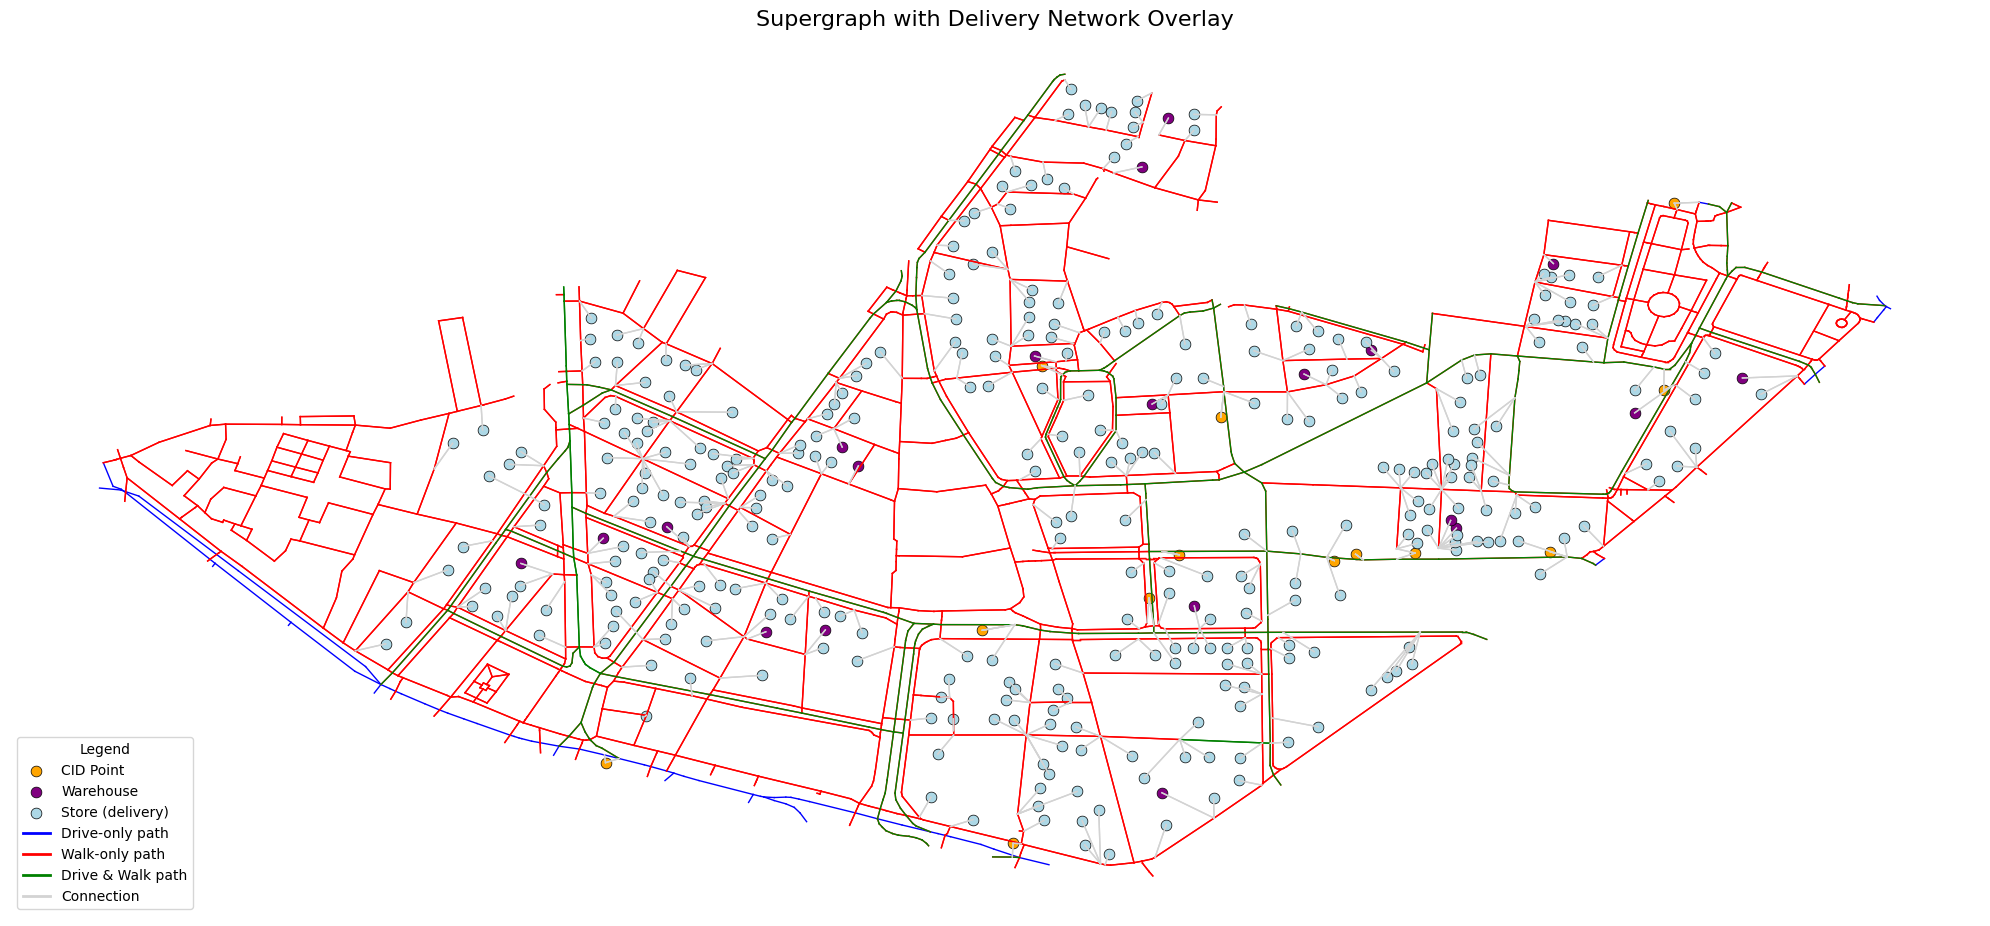

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))
# Mantener proporción real en metros
ax.set_aspect('equal', 'box')

# Colores por modo de arista
edge_colors = {
    'drive': 'blue',
    'walk': 'red',
    'drive+walk': 'green',
    'connection': 'lightgray'
}

# Agrupar aristas por modo\
edges_by_mode = {mode: [] for mode in edge_colors}
for u, v, data in G_super.edges(data=True):
    modos = data.get('mode', [])
    # Determinar clave de modo, priorizando conexiones
    if isinstance(modos, list):
        if 'connection' in modos:
            mode_key = 'connection'
        elif 'drive' in modos and 'walk' in modos:
            mode_key = 'drive+walk'
        elif 'drive' in modos:
            mode_key = 'drive'
        elif 'walk' in modos:
            mode_key = 'walk'
        else:
            mode_key = 'connection'
    else:
        mode_key = modos if modos in edge_colors else 'connection'

    # Coordenadas de los nodos
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode_key].append(((x0, x1), (y0, y1)))

# Dibujar todas las aristas
for mode_key, segments in edges_by_mode.items():
    for xs, ys in segments:
        ax.plot(xs, ys, color=edge_colors[mode_key], linewidth=1)

# Definición de categorías de nodos
categorias = {
    'cid':               {'coords': [], 'color': 'orange',     'label': 'CID Point'},
    'almacen_m3':        {'coords': [], 'color': 'purple',     'label': 'Warehouse'},
    'comercio_entrega':  {'coords': [], 'color': 'lightblue', 'label': 'Store (delivery)'},
    'almacen_y_comercio':{'coords': [], 'color': 'black',      'label': 'Warehouse & Shop'}
}

# Recolectar coordenadas de nodos especiales
for nodo, data in G_super.nodes(data=True):
    tipo = data.get('tipo')
    coord = (data['x'], data['y'])
    if tipo == 'carga':
        categorias['cid']['coords'].append(coord)
    elif tipo == 'almacen' and 'comercio' in nodo:
        categorias['almacen_y_comercio']['coords'].append(coord)
    elif tipo == 'almacen':
        categorias['almacen_m3']['coords'].append(coord)
    elif tipo == 'comercio':
        categorias['comercio_entrega']['coords'].append(coord)

# Dibujar nodos
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=60, edgecolor='k', linewidth=0.5, label=cat['label'])

# Crear leyenda de aristas
from matplotlib.lines import Line2D
edge_legend = [
    Line2D([0], [0], color=edge_colors[m], lw=2, label=lab)
    for m, lab in zip(
        ['drive', 'walk', 'drive+walk', 'connection'],
        ['Drive-only path', 'Walk-only path', 'Drive & Walk path', 'Connection']
    )
]

# Ajustar título y ejes
ax.set_title("Supergraph with Delivery Network Overlay", fontsize=16)
ax.axis('off')

# Combinar leyendas y eliminar duplicados
handles_nodes, labels_nodes = ax.get_legend_handles_labels()
handles = handles_nodes + edge_legend
labels = labels_nodes + [h.get_label() for h in edge_legend]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Legend', fontsize=10)

plt.tight_layout()
plt.show()


## M1 Pipeline

### 0 Configuration

In [58]:
N_PAQUETES = 50               # Número total de paquetes a repartir
PAQUETES_MIN = 1               # Mínimo de paquetes por comercio
PAQUETES_MAX = 5               # Máximo de paquetes por comercio
CAPACIDAD_MAXIMA = 8           # Capacidad máxima que puede cargar el repartidor

### 1 Deliveries sample

In [59]:
# ==============================
# Seleccionar comercios y asignar paquetes
# ==============================

paquetes_asignados = 0
bajos_seleccionados = []
paquetes_por_nodo = []

while paquetes_asignados < N_PAQUETES:
    max_pos = min(PAQUETES_MAX, N_PAQUETES - paquetes_asignados)
    if max_pos < PAQUETES_MIN: break

    nodo = random.choice(nodos_comercios)
    asignado_nodo = sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == nodo)
    disponible_nodo = CAPACIDAD_MAXIMA - asignado_nodo
    if disponible_nodo < PAQUETES_MIN: continue

    paquetes = random.randint(PAQUETES_MIN, min(max_pos, disponible_nodo))
    bajos_seleccionados.append(nodo)
    paquetes_por_nodo.append(paquetes)
    paquetes_asignados += paquetes

# Agrupar y sumar por nodo 
bajos_sample = gpd.GeoDataFrame(
    pd.DataFrame([{
        'nodo': n,
        'paquetes': sum(p for nn, p in zip(bajos_seleccionados, paquetes_por_nodo) if nn == n)
    } for n in set(bajos_seleccionados)]),
    geometry=[Point(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in set(bajos_seleccionados)],
    crs="EPSG:4326"
)

display(bajos_sample)


nodo  paquetes                   geometry
0   comercio_17104         1  POINT (-0.37901 39.47007)
1   comercio_23326         3  POINT (-0.37072 39.47055)
2   comercio_20348         5  POINT (-0.37504 39.46926)
3   comercio_18766         5  POINT (-0.37648 39.47157)
4   comercio_20361         3  POINT (-0.37481 39.46896)
5   comercio_19686         3    POINT (-0.37583 39.472)
6   comercio_21928         5  POINT (-0.37222 39.47127)
7   comercio_22613         5  POINT (-0.37118 39.47172)
8   comercio_17082         3  POINT (-0.37899 39.46966)
9   comercio_21131         3  POINT (-0.37283 39.47132)
10  comercio_17107         2  POINT (-0.37908 39.47035)
11  comercio_15851         3   POINT (-0.3807 39.46967)
12  comercio_21892         5  POINT (-0.37141 39.46994)
13  comercio_20324         2    POINT (-0.375 39.46813)
14  comercio_17102         1  POINT (-0.37874 39.46994)
15  comercio_19638         1  POINT (-0.37638 39.46895)

### 3 FASE 1

#### Asigno cada comercio al mejor CID según tiempo a pie y penalización de viajes extra.


In [ ]:

# --- 1) Funciones de tiempo en G_super ---
def tiempo_por_distancia(distancia_metros, velocidad_kmh):
    """Convierte distancia (m) y velocidad (km/h) a tiempo (min)."""
    return distancia_metros / (velocidad_kmh * 1000 / 60)

def calcular_tiempo_walk(G, origen, destino):
    """Devuelve (minutos, camino) del trayecto a pie más rápido en G_super."""
    try:
        path = nx.shortest_path(G, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), []
    tiempo = sum(
        min(edge_data.get('tiempo_walk', float('inf')) 
            for edge_data in G.get_edge_data(u, v).values())
        for u, v in zip(path[:-1], path[1:])
    )
    return tiempo, path

# --- 2) DataFrames para comercios y CIDs ---
# Asegúrate de que 'bajos_sample' y 'nodos_carga' existen en tu entorno
df_comercios = pd.DataFrame({
    'id':   bajos_sample['nodo'],
    'node': bajos_sample['nodo'],
    'w':    bajos_sample['paquetes'].astype(int)
})

df_cid = pd.DataFrame({
    'id':   nodos_carga,
    'node': nodos_carga
})

# --- 3) Calcula tiempos en aristas y matriz de tiempo a pie ---
n, m = len(df_comercios), len(df_cid)
time_walk = np.zeros((n, m))
for i, ci in df_comercios.iterrows():
    for j, sj in df_cid.iterrows():
        t, _ = calcular_tiempo_walk(G_super, sj['node'], ci['node'])
        time_walk[i, j] = t

# Penalización P = doble del tiempo medio de caminata (min)
P = 2 * np.mean(time_walk)

# --- 4) Heurística Marginal Trips sobre tiempos reales ---
Q = CAPACIDAD_MAXIMA
L = np.zeros(m, dtype=int)
assignments = []

for i, ci in df_comercios.iterrows():
    best_cost, best_j = float('inf'), None
    for j, sj in df_cid.iterrows():
        runs_before = math.ceil(L[j] / Q)
        runs_after  = math.ceil((L[j] + ci['w']) / Q)
        delta_runs  = runs_after - runs_before
        cost = time_walk[i, j] + P * delta_runs
        if cost < best_cost:
            best_cost, best_j = cost, j

    assignments.append({
        'commerce_id': ci['id'],
        'assigned_cid': df_cid.loc[best_j, 'id'],
        'walk_time_min': time_walk[i, best_j],
        'delta_runs': delta_runs
    })
    L[best_j] += ci['w']

# --- 5) Resultados ---
assign_df = pd.DataFrame(assignments)
loads_df  = pd.DataFrame({
    'cid_id':        df_cid['id'],
    'total_load':    L,
    'required_runs': np.ceil(L / Q).astype(int)
})

# Mostrar resultados
print("Asignaciones Fase 1:")
display(assign_df)
print("\nCarga y viajes requeridos por CID:")
display(loads_df)


Asignaciones Fase 1:


commerce_id assigned_cid  walk_time_min  delta_runs
0   comercio_17702     carga_39       3.688755           1
1   comercio_19638     carga_39       5.183258           1
2   comercio_20355    carga_175       1.591235           1
3   comercio_21146    carga_175       6.169262           1
4   comercio_17682     carga_39       2.999187           1
5   comercio_21903    carga_175       4.448651           1
6   comercio_17083     carga_39       2.535825           1
7   comercio_17691     carga_39       4.236859           1
8   comercio_21141     carga_39      11.883846           1
9   comercio_17127     carga_39       4.481823           1
10  comercio_19664     carga_39       6.915961           1
11  comercio_21909    carga_175       4.437144           1
12  comercio_20377    carga_764       0.543601           1
13  comercio_17674     carga_39       3.201858           1
14  comercio_20387    carga_764       2.632280           1
15  comercio_17120     carga_39       5.115298           1
16  comercio_19669    carga_426       0.705976           1


Carga y viajes requeridos por CID:


cid_id  total_load  required_runs
0    carga_39          30              4
1   carga_175           8              1
2   carga_301           0              0
3   carga_426           5              1
4   carga_486           0              0
5   carga_507           0              0
6   carga_596           0              0
7   carga_615           0              0
8   carga_623           0              0
9   carga_733           0              0
10  carga_764           7              1
11  carga_802           0              0
12  carga_865           0              0

### 4 FASE 2

#### Dentro de cada CID, descompongo su demanda en viajes de ≤ Q paquetes, clusterizo y calculo rutas peatonales óptimas.


In [ ]:
import pandas as pd
import numpy as np
import math
import networkx as nx
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def phase2_walk_routes_cvrp(G, assign_df, df_com, df_cid, Q):
    """
    Fase 2 optimizada vía CVRP (OR-Tools).

    Args:
      G          : MultiDiGraph con 'tiempo_walk' en cada arista.
      assign_df  : DataFrame ['commerce_id','assigned_cid'] de la Fase 1.
      df_com     : DataFrame ['id','node','w'].
      df_cid     : DataFrame ['id','node'].
      Q          : capacidad por viaje (paquetes).

    Returns:
      routes_df  : DataFrame con ['cid','batch','sequence','time_min','load'].
      summary    : dict {'tiempo_total_min','num_rutas'}.
    """
    all_routes = []
    total_time = 0.0
    total_batches = 0

    for _, row_cid in df_cid.iterrows():
        cid, depot_node = row_cid['id'], row_cid['node']
        # 1) Comercios asignados a este CID
        asign = assign_df[assign_df['assigned_cid'] == cid]
        if asign.empty:
            continue
        # Preparar listas de nodos y demandas
        locations = [depot_node]  # índice 0 = depósito
        demands   = [0]           # demanda 0 en depósito
        for _, r in asign.iterrows():
            cr = df_com[df_com['id'] == r['commerce_id']].iloc[0]
            locations.append(cr['node'])
            demands.append(int(cr['w']))
        N = len(locations)
        # 2) Construir matriz de tiempos a pie
        time_matrix = [[0]*N for _ in range(N)]
        for i in range(N):
            for j in range(N):
                if i == j:
                    time_matrix[i][j] = 0
                else:
                    t,_ = calcular_tiempo_walk(G, locations[i], locations[j])
                    time_matrix[i][j] = round(t, 3)

        # 3) Número mínimo de vehículos (batches) necesarios
        total_demand = sum(demands)
        R = math.ceil(total_demand / Q)

        # 4) Configurar OR-Tools CVRP
        manager = pywrapcp.RoutingIndexManager(N, R, 0)
        routing = pywrapcp.RoutingModel(manager)

        # Callback de distancia (tiempo)
        def time_callback(from_idx, to_idx):
            i = manager.IndexToNode(int(from_idx))
            j = manager.IndexToNode(int(to_idx))
            return time_matrix[i][j]
        transit_cb = routing.RegisterTransitCallback(time_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_cb)

        # Dimension de capacidad
        def demand_callback(idx):
            node = manager.IndexToNode(idx)
            return demands[node]
        demand_cb = routing.RegisterUnaryTransitCallback(demand_callback)
        routing.AddDimensionWithVehicleCapacity(
            demand_cb,
            0,       # slack
            [Q]*R,   # capacidad por vehículo
            True,    # start cumul to zero
            "Capacity"
        )

        # Parámetros de búsqueda
        search_params = pywrapcp.DefaultRoutingSearchParameters()
        search_params.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        search_params.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        search_params.time_limit.seconds = max(5, total_demand)

        solution = routing.SolveWithParameters(search_params)
        if not solution:
            raise RuntimeError(f"No se encontró solución CVRP para CID {cid}")

        # 5) Extraer rutas
        for vehicle_id in range(R):
            idx = routing.Start(vehicle_id)
            if routing.IsEnd(solution.Value(routing.NextVar(idx))):
                continue  # vehículo no usado
            route_nodes = []
            load = 0
            time = 0
            while not routing.IsEnd(idx):
                node = manager.IndexToNode(idx)
                route_nodes.append(locations[node])
                load += demands[node]
                next_idx = solution.Value(routing.NextVar(idx))
                time += routing.GetArcCostForVehicle(idx, next_idx, vehicle_id)
                idx = next_idx
            # añadir retorno al depósito
            route_nodes.append(depot_node)

            all_routes.append({
                'cid':       cid,
                'batch':     vehicle_id,
                'sequence':  route_nodes,
                'time_min':  time,
                'load':      load
            })
            total_time += time
            total_batches += 1

    routes_df = pd.DataFrame(all_routes)
    summary = {
        'tiempo_total_min': total_time,
        'num_rutas':        total_batches
    }
    return routes_df, summary


# === Ejemplo de uso ===
routes_df, summary = phase2_walk_routes_cvrp(
     G_super,
     assign_df,
     df_comercios,
     df_cid,
     CAPACIDAD_MAXIMA
 )
display(routes_df)
display(summary)


Calculando tiempo de 13 a 1
<class 'int'> <class 'int'>


SystemError: <built-in function RoutingModel_SolveWithParameters> returned a result with an exception set

### 5 FASE 3

#### Con los CID activos, calculo la ruta de furgoneta que los recorre todos, y dimensiono cuántas furgonetas hacen falta según sus horas de trabajo.

In [ ]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import random
from shapely.geometry import Point

# -------------------------------------------------------------------
# Parámetros
HORAS_TRABAJO = 8  # horas por día por furgoneta
# -------------------------------------------------------------------

# --- 1) Selección de depósito periférico usando solo G_super ---
def select_deposit_node(G_super, shp_zone, nodos_carga, thresh_init=0.01, thresh_max=0.1):
    """
    Escoge un nodo en la periferia de shp_zone dentro de G_super
    que tenga conexión válida a algún CID.
    """
    thresh = thresh_init
    while True:
        boundary_nodes = [
            n for n, d in G_super.nodes(data=True)
            if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh
        ]
        if not boundary_nodes:
            thresh = min(thresh * 3, thresh_max)
            if thresh >= thresh_max:
                raise RuntimeError("No se hallaron nodos periféricos válidos.")
            continue
        random.shuffle(boundary_nodes)
        for bnd in boundary_nodes:
            # comprobar conexión a un CID cercano
            lon_b, lat_b = G_super.nodes[bnd]['x'], G_super.nodes[bnd]['y']
            cid_near = min(
                nodos_carga,
                key=lambda c: math.hypot(
                    lon_b - G_super.nodes[c]['x'],
                    lat_b - G_super.nodes[c]['y']
                )
            )
            try:
                path = nx.shortest_path(G_super, bnd, cid_near, weight='tiempo_drive')
                if path:
                    return bnd
            except nx.NetworkXNoPath:
                continue
        thresh = min(thresh * 3, thresh_max)

# --- 2) Función para construir matriz de tiempos de conducción ---
def build_time_matrix(G_super, deposito, cid_nodes):
    """
    Precomputar matriz de tiempos entre depósito y todos los CID.
    """
    all_nodes = [deposito] + cid_nodes
    N = len(all_nodes)
    time_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                time_matrix[i, j] = 0
            else:
                try:
                    path = nx.shortest_path(G_super, all_nodes[i], all_nodes[j], weight='tiempo_drive')
                    t = sum(
                        min(attr.get('tiempo_drive', float('inf'))
                            for attr in G_super.get_edge_data(u, v).values())
                        for u, v in zip(path[:-1], path[1:])
                    )
                    time_matrix[i, j] = t
                except nx.NetworkXNoPath:
                    time_matrix[i, j] = np.inf
    return all_nodes, time_matrix

# --- 3) Greedy TSP usando time_matrix ---
def greedy_drive_with_matrix(deposito, cid_nodes, all_nodes, time_matrix):
    """
    Heurística nearest-neighbor usando matriz de tiempos.
    Sin retorno al depósito.
    """
    idx_map = {node: idx for idx, node in enumerate(all_nodes)}
    unvisited = set(cid_nodes)
    ruta = [deposito]
    tiempo = 0.0
    current = deposito

    while unvisited:
        curr_idx = idx_map[current]
        # elegir siguiente con menor tiempo
        best_node, best_time = min(
            ((node, time_matrix[curr_idx, idx_map[node]]) for node in unvisited),
            key=lambda x: x[1]
        )
        if not np.isfinite(best_time):
            print(f"Warning: no hay camino a {best_node} desde {current}.")
            raise RuntimeError(f"No reachable CID from {current}: {unvisited}")
        ruta.append(best_node)
        tiempo += best_time
        current = best_node
        unvisited.remove(best_node)

    return ruta, tiempo

# --- 4) Función general de Fase 3 con matriz ---
def phase3_truck_route_matrix(G_super, df_cid, shp_zone, max_attempts=5):
    """
    Ruta de furgoneta sin retorno y dimensionamiento usando matriz precomputada.
    """
    cid_nodes = df_cid['node'].tolist()
    for _ in range(max_attempts):
        try:
            deposito = select_deposit_node(G_super, shp_zone, cid_nodes)
            all_nodes, time_matrix = build_time_matrix(G_super, deposito, cid_nodes)
            sequence, tiempo_total = greedy_drive_with_matrix(deposito, cid_nodes, all_nodes, time_matrix)
            num_furgonetas = math.ceil(tiempo_total / (HORAS_TRABAJO * 60))
            route_df = pd.DataFrame([{
                'deposito':       deposito,
                'sequence':       sequence,
                'time_min':       tiempo_total,
                'num_furgonetas': num_furgonetas
            }])
            summary = {
                'tiempo_total_min': tiempo_total,
                'num_furgonetas':   num_furgonetas
            }
            return route_df, summary
        except RuntimeError:
            continue
    raise RuntimeError("No se pudo generar ruta de furgoneta con matriz.")

# === Ejemplo de uso ===
route_df, summary = phase3_truck_route_matrix(G_super, df_cid, shp_zone)
print(route_df)
print(summary)


RuntimeError: No se pudo generar ruta de furgoneta con matriz.